In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import sys
#!{sys.executable} -m pip install sagemaker -U
#!{sys.executable} -m pip install sagemaker-experiments

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import xgboost as xgb

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

%cd /root/predicting-coronavirus
%pip install mpu
import src.data_import as di
#import src.data_tools as dt
import src.airport_index as ap

%matplotlib inline
pd.set_option('display.max_columns', 500)  
pd.set_option('display.max_rows', 500)   

/root/predicting-coronavirus
  Using cached mpu-0.23.0-py3-none-any.whl (70 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

In [5]:
!cd data/covid-19-data;git pull origin master

From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD
Already up to date.


In [6]:
account_id = sess.client('sts', region_name=sess.region_name).get_caller_identity()["Account"]
bucket = 'sagemaker-studio-{}-{}'.format(sess.region_name, account_id)
prefix = 'capstone2'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good. Uploading the data files...")

# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3url = S3Uploader.upload('data/covid-19-data/us-counties.csv', 's3://{}/{}/{}'.format(bucket, prefix,'nyt'))
print(s3url)


s3://sagemaker-studio-us-east-1-752222400982/capstone2/nyt/us-counties.csv


In [7]:
#etl = dt.etl()
#nyt = etl.load_nyt()
nyt = di.extract_nyt()

In [8]:
nyt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142696 entries, 0 to 144325
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   fips    142696 non-null  int64         
 1   date    142696 non-null  datetime64[ns]
 2   deaths  142696 non-null  int64         
 3   cases   142696 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 5.4 MB


In [140]:
nyt[nyt['cases'] > 10]

,fips,date,deaths,cases
235,31055,2020-02-20,0,11
249,31055,2020-02-21,0,11
263,31055,2020-02-22,0,11
277,31055,2020-02-23,0,11
292,31055,2020-02-24,0,12
...,...,...,...,...
144316,56023,2020-05-14,0,14
144317,56025,2020-05-14,0,49
144320,56033,2020-05-14,0,16
144322,56037,2020-05-14,0,21


In [9]:
#Get the maximum cases and deaths for each fips
max_cases = nyt.groupby('fips').max()
max_cases = max_cases[['cases', 'deaths']]
#max_cases['deaths'].sum()
#max_cases

In [10]:
hhi = di.extract_hhi()
edu = di.extract_edu()
pubtrans = di.extract_public_transport()
housing = di.extract_housing()
election = di.extract_election()
geo = di.extract_geography()
counties = ap.extract_geography()
airports = ap.extract_airports()
intl_index = ap.build_intl_arrivals_index_df2(counties, airports, 30, 200)
sip = di.extract_sip()


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/root/predicting-coronavirus/src/data_import.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['hs'] = ret['hs']/100
/root/predicting-coronavirus/src/data_import.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['ba_plus'] = ret['ba_plus']/100
/root/predicting-coronavirus/src/data_import.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

<class 'pandas.core.series.Series'>


In [11]:
per100k = pd.merge(nyt, geo, how='inner', left_on=['fips'], right_on=['fips'])
per100k = per100k[['fips', 'state', 'population', 'date', 'cases', 'deaths']]
per100k['death_rate'] = per100k.apply(lambda row: (row['deaths']/row['population'])*100000, axis=1)
per100k['case_rate'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)
per100k


,fips,state,population,date,cases,deaths,death_rate,case_rate
0,53061,Washington,713335,2020-01-21,1,0,0.000000,0.140187
1,53061,Washington,713335,2020-01-22,1,0,0.000000,0.140187
2,53061,Washington,713335,2020-01-23,1,0,0.000000,0.140187
3,53061,Washington,713335,2020-01-24,1,0,0.000000,0.140187
4,53061,Washington,713335,2020-01-25,1,0,0.000000,0.140187
...,...,...,...,...,...,...,...,...
142691,31147,Nebraska,8363,2020-05-14,1,0,0.000000,11.957432
142692,40149,Oklahoma,11629,2020-05-14,1,0,0.000000,8.599192
142693,46123,South Dakota,5644,2020-05-14,1,0,0.000000,17.717931
142694,55013,Wisconsin,15457,2020-05-14,1,1,6.469561,6.469561


In [12]:
ten = per100k[per100k['case_rate'] > 10].groupby('fips').min()
ten = ten[['date']]
ten.columns = ['date_10']
#ten['date_10'].fillna(datetime(2020,5,15))

In [53]:
# Temportal stuff
ts_df = pd.merge(per100k, ten, how='left', left_on=['fips'], right_on=['fips'])
ts_df = pd.merge(ts_df, sip, how='left', left_on=['state'], right_on=['state'])


In [54]:
def days_since(row, calc_date):
    row['days_since_sip'] = int((row['date'] - row['sip']).days)
    lifted = -int((row['date'] - row['sip_lifted']).days)
    if(lifted < 0):
        lifted = 0
    row['days_since_sip_lifted'] = lifted
    ten_per = row['date_10']
    if pd.isnull(ten_per):
        row['days_since_10p100k'] = 0
    else:
        row['days_since_10p100k'] = int((row['date'] - ten_per).days)
    return row
ts_df['case_rate'] = ts_df['case_rate'].fillna(0)
ts_df['death_rate'] = ts_df['death_rate'].fillna(0)
ts_df = ts_df.apply(days_since, axis=1, args=[(datetime(2020,5,15))])


In [16]:
ts_df.to_csv('./data/ts_df.csv')


In [55]:
ts_df = pd.read_csv('./data/ts_df.csv')

In [17]:
# Geography and demographics
big_df = pd.merge(geo, hhi, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, edu, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, housing, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, pubtrans, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, election, how='left', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, intl_index[['fips', 'international']], how='left', left_on=['fips'], right_on=['fips'])


In [18]:
big_df

,sc,fips,state,county,population,area-km,households,mean_hhi,median_hhi,pop_over_25,hs,ba_plus,ma_plus,pop_over_65,median_house_price,median_rent,percent_big_buildings,percent_commuter,per_dem,per_gop,international
0,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522,83501,56813,80251,155691,0.283,0.207,0.107,44443,193800,1057,0.141,0.0,0.195653,0.773515,1.000000e+00
1,Alabama:Calhoun,1015,Alabama,Calhoun,118572,1569.190,44264,45818,61117,79172,0.325,0.100,0.080,20515,121800,743,0.020,0.7,0.278559,0.692397,2.418858e+06
2,Alabama:Cullman,1043,Alabama,Cullman,80406,1903.228,30323,44612,67585,58319,0.311,0.084,0.037,15541,127700,710,0.008,0.0,0.100059,0.878105,1.000000e+00
3,Alabama:DeKalb,1049,Alabama,DeKalb,71109,2012.662,26462,36998,57354,48169,0.298,0.082,0.067,12261,112000,670,0.000,0.0,0.141149,0.834892,1.505138e+06
4,Alabama:Elmore,1051,Alabama,Elmore,79303,1601.868,30155,60796,70961,56793,0.325,0.179,0.074,12299,166300,837,0.002,0.0,0.228587,0.748381,7.020105e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,Wisconsin:Waukesha,55133,Wisconsin,Waukesha,389891,1423.389,158368,86968,115491,284512,0.221,0.295,0.161,75079,290500,1029,0.096,0.5,0.339516,0.610962,3.195409e+06
823,Wisconsin:Winnebago,55139,Wisconsin,Winnebago,166994,1125.316,71332,56589,75157,115949,0.326,0.183,0.069,27997,149200,735,0.067,0.5,0.431402,0.505833,2.330446e+04
824,Wisconsin:Wood,55141,Wisconsin,Wood,74749,2054.162,32274,55273,69755,52200,0.386,0.146,0.080,14940,129400,743,0.049,0.0,0.377387,0.570163,1.000000e+00
825,Wyoming:Laramie,56021,Wyoming,Laramie,91738,6956.480,39678,64306,84033,68017,0.286,0.177,0.087,16163,246500,893,0.058,0.0,0.289698,0.621955,2.970518e+05


In [19]:
big_df['percent_over_65'] = big_df['pop_over_65']/big_df['population']
big_df['percent_over_25'] = big_df['pop_over_25']/big_df['population']
big_df['pop_density'] = big_df['population']/big_df['area-km']
big_df['hh_density'] = big_df['households']/big_df['area-km']



demo_df = big_df.drop(['pop_over_65', 'pop_over_25', 'population', 'households','area-km'], axis=1)



In [20]:
final_df = pd.merge(ts_df, demo_df, how='inner', left_on=['fips'], right_on=['fips'])

In [21]:
final_df = final_df[['fips',
                     #'date',
                     'death_rate',
                     'case_rate',
                     'days_since_sip',
                     'days_since_sip_lifted',
                     'days_since_10p100k',
                     'median_hhi',
                     'hs',
                     'ba_plus',
                     'ma_plus',
                     'median_house_price',
                     'median_rent',
                     'percent_big_buildings',
                     'percent_commuter',
                     'international',
                     'percent_over_65',
                     'pop_density',
                     'hh_density'
                    ]].set_index('fips')

In [22]:
final_df

,death_rate,case_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k,median_hhi,hs,ba_plus,ma_plus,median_house_price,median_rent,percent_big_buildings,percent_commuter,international,percent_over_65,pop_density,hh_density
fips,,,,,,,,,,,,,,,,,
53061,0.0,0.140187,-62,0,-51,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
53061,0.0,0.140187,-61,0,-50,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
53061,0.0,0.140187,-60,0,-49,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
53061,0.0,0.140187,-59,0,-48,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
53061,0.0,0.140187,-58,0,-47,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39145,0.0,16.352407,49,9,21,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464
39145,0.0,16.352407,50,10,22,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464
39145,0.0,16.352407,51,11,23,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464


In [23]:
final_df.to_csv('./data/final_df.csv')

In [28]:
final_df = pd.read_csv('./data/final_df.csv')

In [52]:
corr

,death_rate,case_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k,median_hhi,hs,ba_plus,ma_plus,median_house_price,median_rent,percent_big_buildings,percent_commuter,international,percent_over_65,pop_density,hh_density
death_rate,1.000000,0.844371,0.357520,0.063412,0.428935,0.173197,-0.028213,0.086275,0.139125,0.095186,0.137897,0.114101,0.271681,0.412276,-0.035837,0.212130,0.187749
case_rate,0.844371,1.000000,0.348880,0.079547,0.442175,0.175756,-0.025687,0.073065,0.135949,0.108747,0.159013,0.139269,0.300180,0.442134,-0.065406,0.226116,0.201669
days_since_sip,0.357520,0.348880,1.000000,0.344749,0.817376,-0.026581,0.080943,-0.098440,-0.036175,-0.024047,-0.026630,-0.125721,-0.021557,0.027996,0.015585,-0.047628,-0.049181
days_since_sip_lifted,0.063412,0.079547,0.344749,1.000000,0.391050,-0.077232,0.029086,-0.042140,-0.060786,-0.082633,-0.060466,-0.044713,-0.083968,-0.068556,0.003339,-0.049042,-0.044611
days_since_10p100k,0.428935,0.442175,0.817376,0.391050,1.000000,0.030445,-0.002686,0.034384,0.057679,-0.019165,0.002247,-0.015361,0.003287,0.044940,0.008561,-0.015769,-0.014253
median_hhi,0.173197,0.175756,-0.026581,-0.077232,0.030445,1.000000,-0.644725,0.780104,0.712642,0.800933,0.843708,0.416350,0.464557,0.502241,-0.091827,0.342119,0.333583
hs,-0.028213,-0.025687,0.080943,0.029086,-0.002686,-0.644725,1.000000,-0.786991,-0.734706,-0.620923,-0.637417,-0.492476,-0.356088,-0.151419,0.182202,-0.278368,-0.282627
ba_plus,0.086275,0.073065,-0.098440,-0.042140,0.034384,0.780104,-0.786991,1.000000,0.796816,0.601233,0.635551,0.509699,0.372023,0.253588,-0.119746,0.317737,0.320727
ma_plus,0.139125,0.135949,-0.036175,-0.060786,0.057679,0.712642,-0.734706,0.796816,1.000000,0.572257,0.598059,0.519069,0.513646,0.278590,-0.095783,0.372180,0.379910
median_house_price,0.095186,0.108747,-0.024047,-0.082633,-0.019165,0.800933,-0.620923,0.601233,0.572257,1.000000,0.881669,0.494822,0.521778,0.395024,-0.000158,0.406297,0.403299


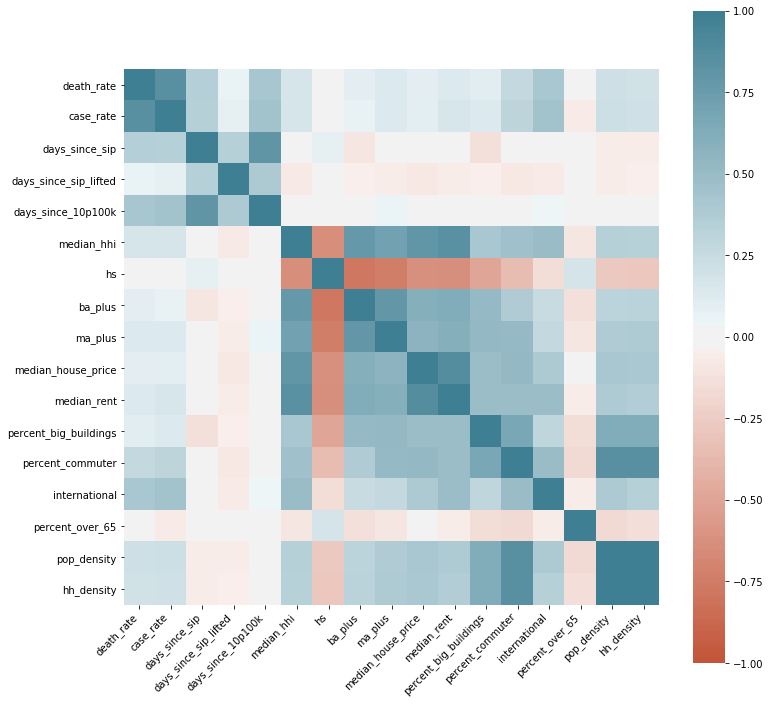

In [144]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,12))

def make_corr(final_df, ax):
    corr = final_df.drop(['fips'], axis=1).corr()
    sns.heatmap(
        corr, 
        ax=ax,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
make_corr(final_df, ax)

In [128]:
y = final_df['case_rate']
X = final_df.drop(['case_rate', 'death_rate'], axis=1).set_index('fips')

In [152]:
# Dumb model
predicted = np.full(len(y_test), np.mean(y_test))


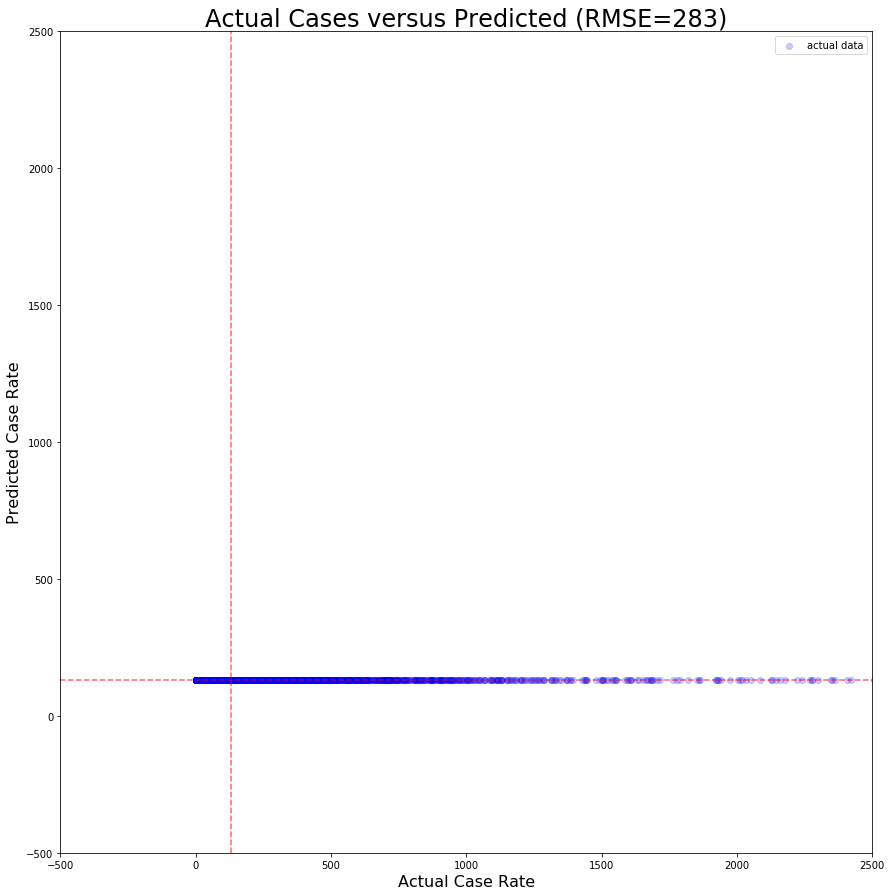

In [160]:
def plot_actual_vs_predicted(y_test, predicted):
    rmse = sqrt(mean_squared_error(y_test, predicted))
    fig, ax = plt.subplots(figsize=(12,12))
    fig.tight_layout()
    plt.scatter(y_test, predicted, color = 'blue', label="actual data", alpha=0.2) 

    ax.set_title('Actual Cases versus Predicted (RMSE={:.0f})'.format(rmse), fontsize=24) 
    ax.legend()
    ax.set_xlabel('Actual Case Rate', fontsize=16)
    ax.set_ylabel('Predicted Case Rate', fontsize=16)
    plt.axvline(x=np.mean(y_test), color='r', linestyle='--', alpha=0.6)
    plt.axhline(y=np.mean(predicted), color='r', linestyle='--', alpha=0.6)
    plt.xlim(-500, 2500)
    plt.ylim(-500, 2500)
    plt.show()
plot_actual_vs_predicted(y_test, predicted)

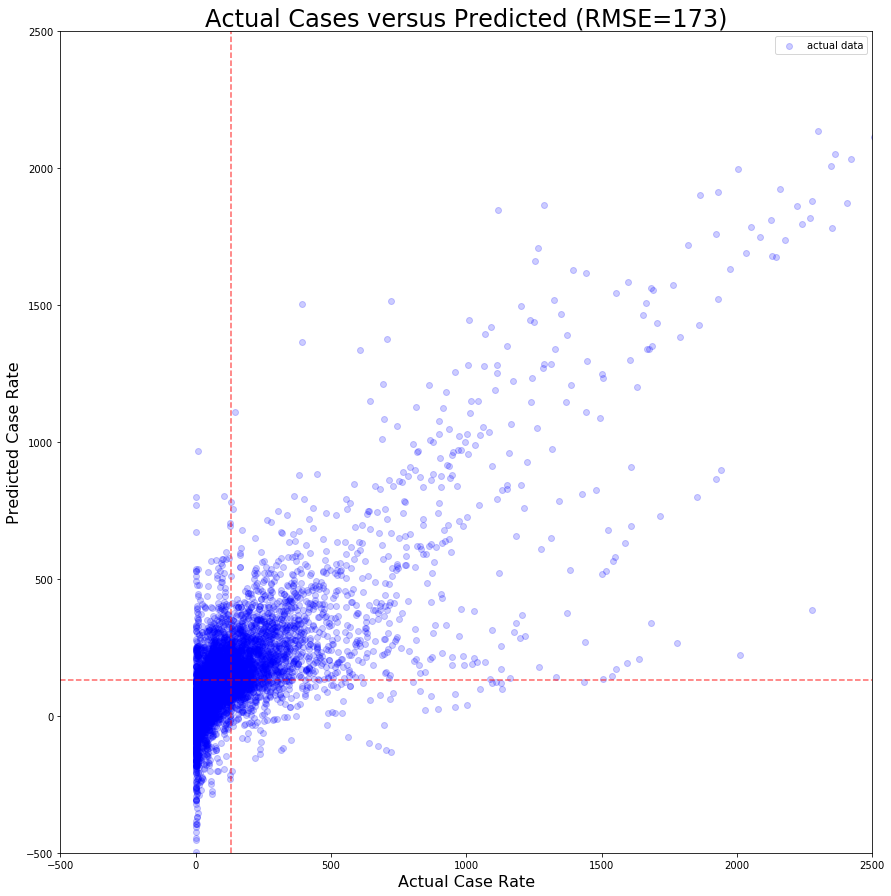

In [161]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
poly.fit(X_train_poly, y_train)
lin = LinearRegression()
lin.fit(X_train_poly, y_train)
X_test_poly = poly.fit_transform(X_test)
predicted = lin.predict(X_test_poly)
plot_actual_vs_predicted(y_test, predicted)


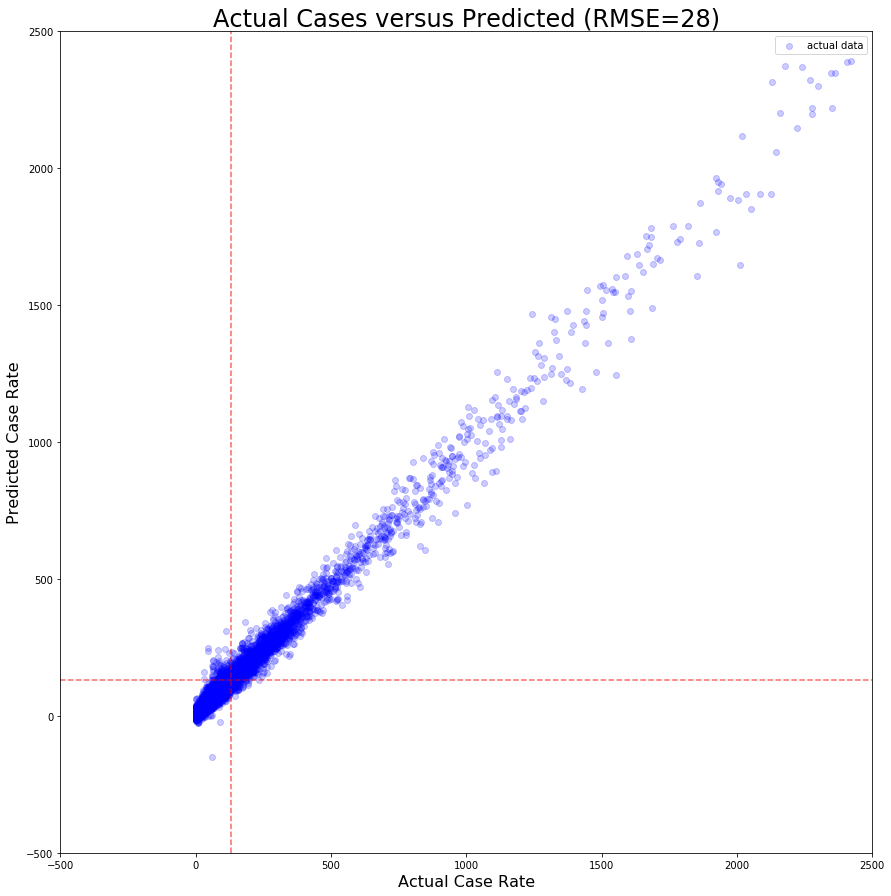

In [162]:
#Un-tuned xgboost
xgbr = xgb.XGBRegressor()
xgbr.fit(X_train, y_train)
predicted = xgbr.predict(X_test)
tp = xgbr.predict(X_train)
plot_actual_vs_predicted(y_test, predicted)

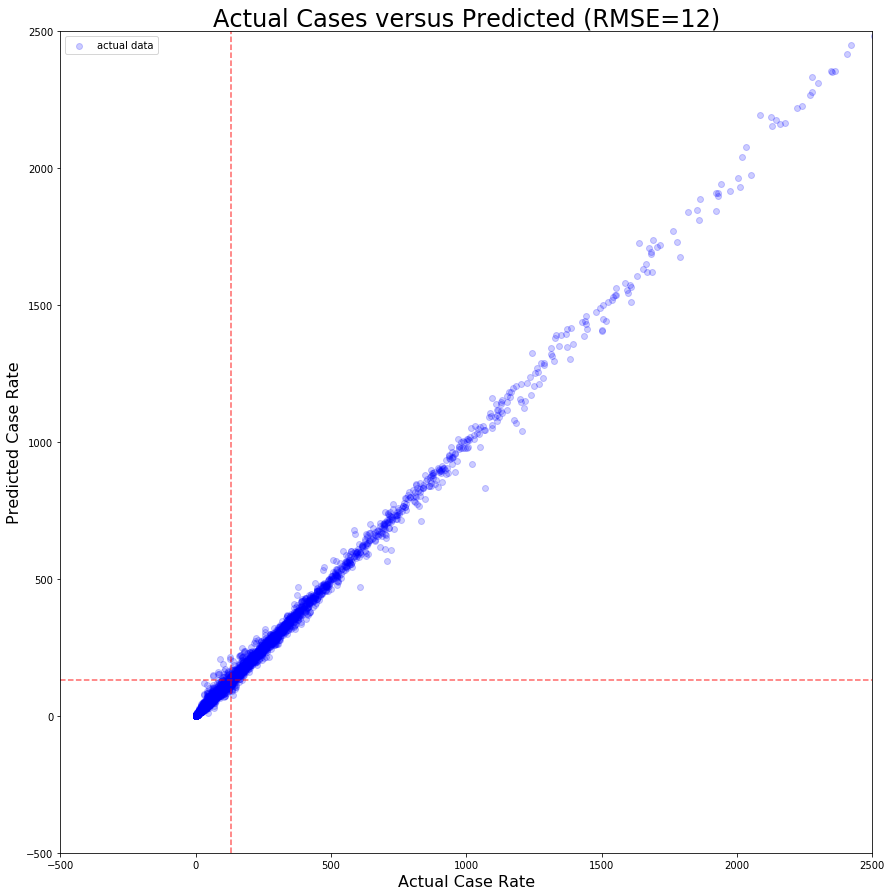

In [163]:
#Tuned xgboost
xgbr = xgb.XGBRegressor(num_round=30, 
                        objective='reg:squarederror',
                        verbosity=1,
                        eta=0.1,
                        subsample=0.78,
                        min_child_weight=3,
                        gamma=4,
                        max_depth=15)
xgbr.fit(X_train, y_train)
predicted = xgbr.predict(X_test)
tp = xgbr.predict(X_train)
plot_actual_vs_predicted(y_test, predicted)

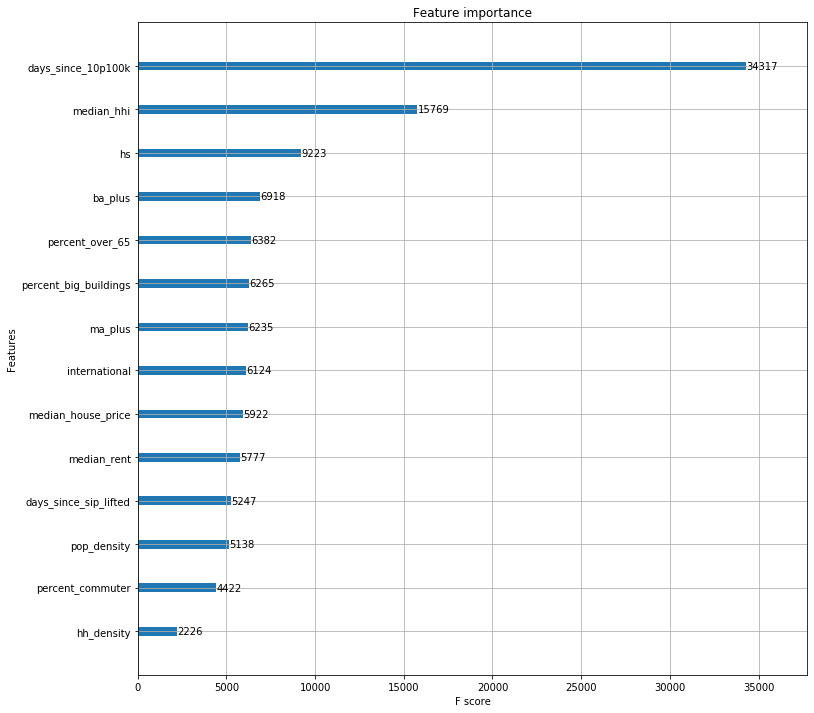

In [91]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(xgbr, ax=ax)

In [165]:
# Engineered features only
y = final_df['case_rate']
X = final_df[['days_since_sip', 'days_since_sip_lifted', 'days_since_10p100k']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


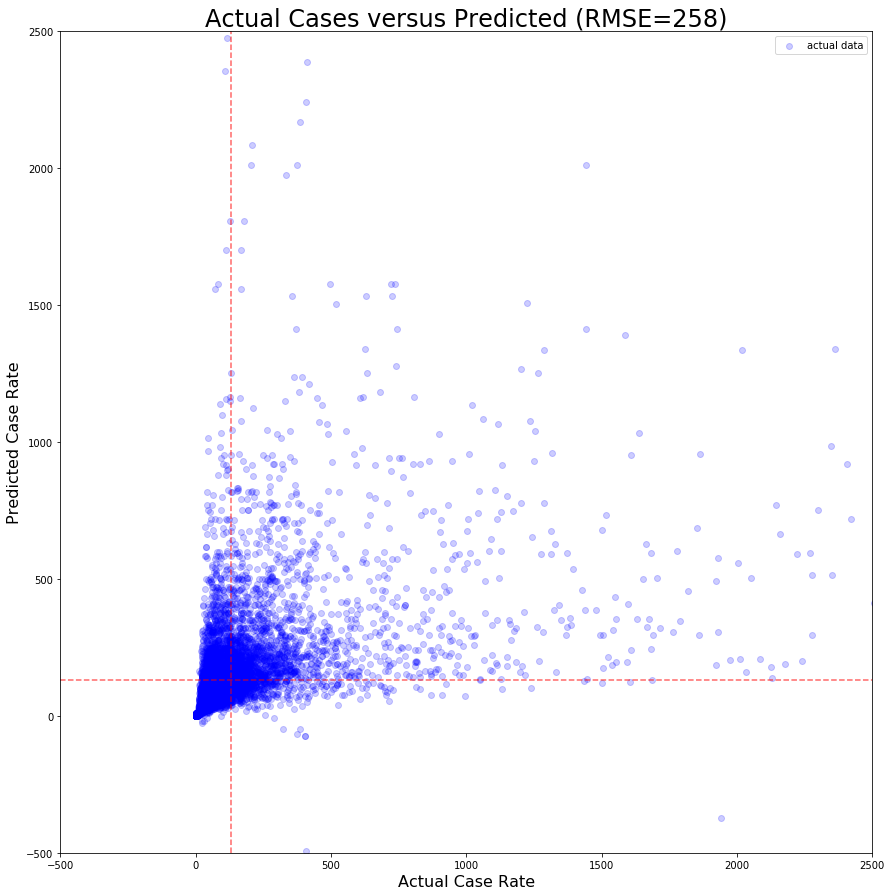

In [166]:
xgbr = xgb.XGBRegressor(num_round=30, 
                        objective='reg:squarederror',
                        verbosity=1,
                        eta=0.1,
                        subsample=0.78,
                        min_child_weight=3,
                        gamma=4,
                        max_depth=15)
xgbr.fit(X_train, y_train)
predicted = xgbr.predict(X_test)
plot_actual_vs_predicted(y_test, predicted)

In [173]:
# Engineered features only
y = final_df['case_rate']
X = final_df.drop(['days_since_sip', 'days_since_sip_lifted', 'days_since_10p100k', 'death_rate', 'case_rate', 'fips'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [174]:
X

,median_hhi,hs,ba_plus,ma_plus,median_house_price,median_rent,percent_big_buildings,percent_commuter,international,percent_over_65,pop_density,hh_density
0,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
1,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
2,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
3,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
4,105073,0.234,0.221,0.106,455000,1525,0.091,5.9,1.742643e+06,0.154041,131.952143,55.533533
...,...,...,...,...,...,...,...,...,...,...,...,...
49282,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464
49283,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464
49284,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464
49285,53019,0.449,0.091,0.060,99700,598,0.041,0.0,5.881750e+04,0.170141,50.301656,18.171464


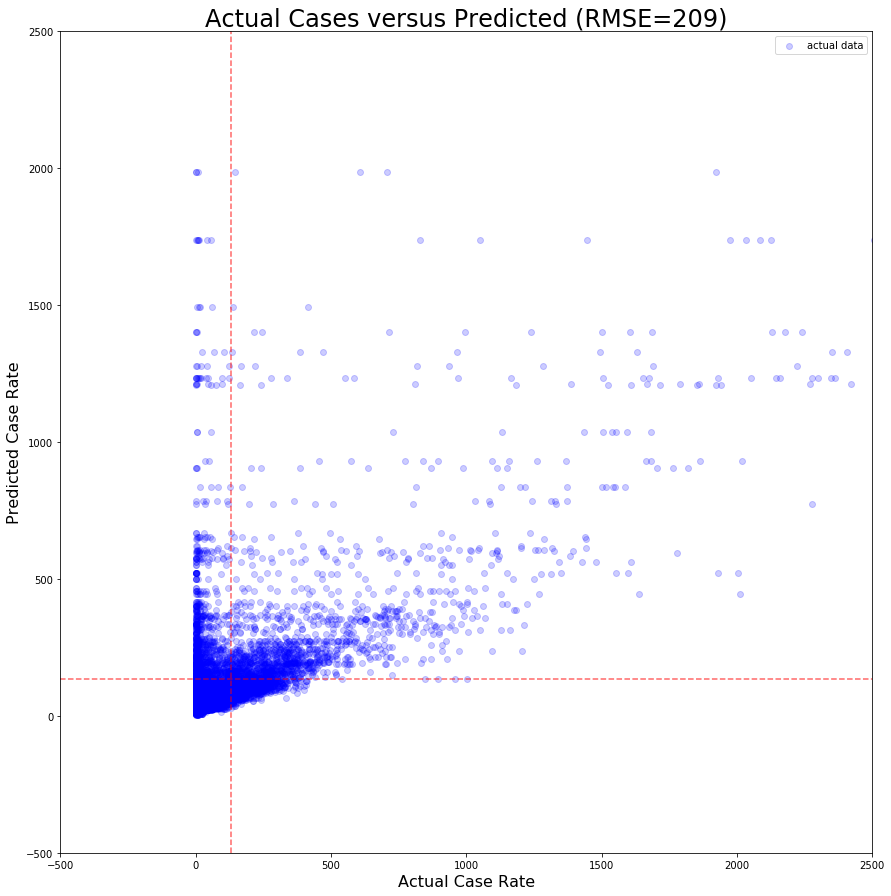

In [175]:
xgbr = xgb.XGBRegressor(num_round=30, 
                        objective='reg:squarederror',
                        verbosity=1,
                        eta=0.1,
                        subsample=0.78,
                        min_child_weight=3,
                        gamma=4,
                        max_depth=15)
xgbr.fit(X_train, y_train)
predicted = xgbr.predict(X_test)
plot_actual_vs_predicted(y_test, predicted)